## NLP - Predict tags on StackOverflow with linear models ##

### Week-1 ###

### Data ###

In [ ]:
! wget https://raw.githubusercontent.com/hse-aml/natural-language-processing/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab

In [3]:
import sys
print(sys.path)

['', '/usr/lib/python35.zip', '/usr/lib/python3.5', '/usr/lib/python3.5/plat-x86_64-linux-gnu', '/usr/lib/python3.5/lib-dynload', '/usr/local/lib/python3.5/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.5/dist-packages/IPython/extensions', '/root/.ipython', '..', '..']


In [1]:
import sys
sys.path.append("..")
from common.download_utils import download_week1_resources

download_week1_resources()

HBox(children=(IntProgress(value=0, max=7196138), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2166270), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1041379), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5091), HTML(value='')))

### Gradeing ###

In [2]:
from grader import Grader
grader = Grader()

### Text Pre-Processing ###

In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
from ast import literal_eval
import pandas as pd
import numpy as np

In [5]:
def read_data(filename):
    data = pd.read_csv(filename,sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [8]:
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv',sep='\t')

In [9]:
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


In [10]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

In [11]:
import re

In [12]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()
    text = re.sub(REPLACE_BY_SPACE_RE," ",text)
    text = re.sub(BAD_SYMBOLS_RE,"",text)
    text = " " + text + " "
    for sw in STOPWORDS:
        text = text.replace(" "+sw+" ", " ")
    text = re.sub('[ ][ ]+', " ", text)
    if text[0] == ' ':
        text = text[1:]
    if text[-1] == ' ':
        text = text[:-1]
    return text

In [13]:
def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [14]:
print(test_text_prepare())

Basic tests are passed.


In [15]:
prepared_questions = []
for line in open('data/text_prepare_tests.tsv', encoding='utf-8'):
    line = text_prepare(line.strip())
    prepared_questions.append(line)
text_prepare_results = '\n'.join(prepared_questions)

grader.submit_tag('TextPrepare', text_prepare_results)

Current answer for task TextPrepare is:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...


In [16]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [17]:
X_train[:3]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app']

### Words Tags Count

In [18]:
from collections import Counter
tags_counts = Counter() 
words_counts = Counter()
for s in X_train:
    for word in s.split():
        # print(word)
        words_counts[word] += 1

for l in y_train:
    for t in l:
        tags_counts[t] += 1

In [19]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

grader.submit_tag('WordsTagsCount', '%s\n%s' % (','.join(tag for tag, _ in most_common_tags), 
                                                ','.join(word for word, _ in most_common_words)))

Current answer for task WordsTagsCount is:
 javascript,c#,java
using,php,java...


In [20]:
DICT_SIZE = 5000
WORDS_TO_INDEX = {p[0]:i for i,p in enumerate(most_common_words[:DICT_SIZE])}
INDEX_TO_WORDS = {WORDS_TO_INDEX[k]:k for k in WORDS_TO_INDEX}
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):

    result_vector = np.zeros(dict_size)
    for word in text.split():
        if word in words_to_index:
            result_vector[words_to_index[word]] += 1
    return result_vector

In [21]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [22]:
print(test_my_bag_of_words())

Basic tests are passed.


In [23]:
from scipy import sparse as sp_sparse

In [24]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


In [25]:
print(most_common_words[:10])
for w in X_train[10].split():
    print(w)
    print(w in WORDS_TO_INDEX)

[('using', 8278), ('php', 5614), ('java', 5501)]
obtaining
False
object
False
javalangclasst
False
object
False
parameterized
False
type
False
without
False
constructing
False
class
False
q_uestion
False


In [37]:
print(X_train[11])

ipad selecting text inside text input tap


In [42]:
print(X_test_mybag[11].toarray())

[[ 0.  0.  0. ...,  0.  0.  0.]]


In [43]:
row = X_train_mybag[10].toarray()[0]
non_zero_elements_count = np.count_nonzero(row)
grader.submit_tag('BagOfWords', str(non_zero_elements_count))

Current answer for task BagOfWords is:
 0...


### TF-IDF

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
def tfidf_features(X_train, X_val, X_test):

    
    
    tfidf_vectorizer = TfidfVectorizer(token_pattern='(\S+)', min_df=5, max_df=0.9, ngram_range=(1,2)) ####### YOUR CODE HERE #######
    
    tfidf_vectorizer.fit(X_train)
    X_train = tfidf_vectorizer.transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)
    
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

In [30]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [31]:
print(X_train[:10])

['draw stacked dotplot r', 'mysql select records datetime field less specified value', 'terminate windows phone 81 app', 'get current time specific country via jquery', 'configuring tomcat use ssl', 'awesome nested set plugin add new children tree various levels', 'create map json response ruby rails 3', 'rspec test method called', 'springboot catalina lifecycle exception', 'import data excel mysql database using php']


In [32]:
print('c++' in tfidf_vocab)
print('c#' in tfidf_vocab)
print('java' in tfidf_vocab)

True
True
True


### MultiLabel Classifier 

In [44]:
from sklearn.preprocessing import MultiLabelBinarizer

In [45]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

In [46]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [47]:
def train_classifier(X_train, y_train, C=1.0, penalty='l2'):
    lr = LogisticRegression(C=C, penalty=penalty)
    ovr = OneVsRestClassifier(lr)
    ovr.fit(X_train, y_train)
    return ovr

In [48]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

In [49]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

In [50]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails




### Evaluation 

In [51]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [52]:
def print_evaluation_scores(y_val, predicted):
    
    accuracy = accuracy_score(y_val, predicted)
    print(f1_score(y_val, predicted, average='weighted'))

In [53]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0827572601681
Tfidf
0.614373712431


In [54]:
from metrics import roc_auc
%matplotlib inline

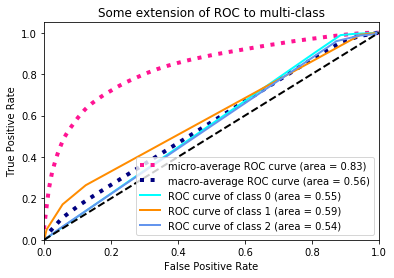

In [55]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

In [56]:
def evaluate(C, penalty):
    classifier_mybag = train_classifier(X_train_mybag, y_train, C, penalty)
    classifier_tfidf = train_classifier(X_train_tfidf, y_train, C, penalty)
    y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
    y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

    y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
    y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)
    print('Bag-of-words')
    print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
    print('Tfidf')
    print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

In [57]:
evaluate(C=10.0, penalty='l2')

Bag-of-words


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0827572601681
Tfidf
0.654071053015


In [58]:
import time
print(time.time())
print(evaluate(C=100.0, penalty='l2'))
print(time.time())
print(evaluate(C=30.0, penalty='l2'))
print(time.time())
print(evaluate(C=3.0, penalty='l2'))
print(time.time())
print(evaluate(C=100.0, penalty='l1'))
print(time.time())
print(evaluate(C=30.0, penalty='l1'))
print(time.time())
print(evaluate(C=3.0, penalty='l1'))
print(time.time())
print(evaluate(C=3.0, penalty='l1'))
print(time.time())

1566196001.138397
Bag-of-words


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0827572601681
Tfidf
0.627385853899
None
1566196097.9177742
Bag-of-words


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0827572601681
Tfidf
0.646472700276
None
1566196175.619567
Bag-of-words


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0827572601681
Tfidf
0.64516880188
None
1566196231.7877183
Bag-of-words


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0827572601681
Tfidf
0.587543547567
None
1566196506.7548547
Bag-of-words


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0827572601681
Tfidf
0.618458006032
None
1566196673.6065445
Bag-of-words


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0827572601681
Tfidf
0.663121639148
None
1566196733.6192746
Bag-of-words


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0827572601681
Tfidf
0.663115031895
None
1566196850.413798


In [59]:
print(time.time())
print(evaluate(C=1.0, penalty='l1'))
print(time.time())
print(evaluate(C=10.0, penalty='l1'))
print(time.time())

print(evaluate(C=0.3, penalty='l1'))
print(time.time())
print(evaluate(C=0.3, penalty='l2'))
print(time.time())

1566196854.0311835
Bag-of-words


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0827572601681
Tfidf
0.652393076154
None
1566196903.4699805
Bag-of-words


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0827572601681
Tfidf
0.64806976689
None
1566197003.9985635
Bag-of-words


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0827572601681
Tfidf
0.620400017537
None
1566197054.291097
Bag-of-words


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0827572601681
Tfidf
0.529995593549
None
1566197099.4777505


In [60]:
classifier_tfidf = train_classifier(X_train_tfidf, y_train, C=3.0, penalty='l1')
y_test_predicted_labels_tfidf = classifier_tfidf.predict(X_test_tfidf)

In [61]:
test_predictions = y_test_predicted_labels_tfidf 
test_pred_inversed = mlb.inverse_transform(test_predictions)

test_predictions_for_submission = '\n'.join('%i\t%s' % (i, ','.join(row)) for i, row in enumerate(test_pred_inversed))
grader.submit_tag('MultilabelClassification', test_predictions_for_submission)

Current answer for task MultilabelClassification is:
 0	mysql,php
1	html,javascript,jquery
2	
3	javascript,jquery
4	android,java
5	parsing,php,xml
6	json,...


In [62]:
print(classifier_tfidf.coef_.shape)
print(mlb.classes)
print(mlb.classes.index('ajax'))
# sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
coef=classifier_tfidf.coef_[mlb.classes.index('ajax')]
cd = {i:coef[i] for i in range(len(coef))}
scd=sorted(cd.items(), key=lambda x: x[1], reverse=True)
print(scd[:3],scd[-3:])

(100, 18305)
['.net', 'ajax', 'algorithm', 'android', 'angularjs', 'apache', 'arrays', 'asp.net', 'asp.net-mvc', 'c', 'c#', 'c++', 'class', 'cocoa-touch', 'codeigniter', 'css', 'csv', 'database', 'date', 'datetime', 'django', 'dom', 'eclipse', 'entity-framework', 'excel', 'facebook', 'file', 'forms', 'function', 'generics', 'google-maps', 'hibernate', 'html', 'html5', 'image', 'ios', 'iphone', 'java', 'javascript', 'jquery', 'json', 'jsp', 'laravel', 'linq', 'linux', 'list', 'loops', 'maven', 'mongodb', 'multithreading', 'mysql', 'node.js', 'numpy', 'objective-c', 'oop', 'opencv', 'osx', 'pandas', 'parsing', 'performance', 'php', 'pointers', 'python', 'python-2.7', 'python-3.x', 'qt', 'r', 'regex', 'rest', 'ruby', 'ruby-on-rails', 'ruby-on-rails-3', 'selenium', 'servlets', 'session', 'sockets', 'sorting', 'spring', 'spring-mvc', 'sql', 'sql-server', 'string', 'swift', 'swing', 'twitter-bootstrap', 'uitableview', 'unit-testing', 'validation', 'vb.net', 'visual-studio', 'visual-studio-20

In [63]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    
    idx = tags_classes.index(tag)
    coef=classifier_tfidf.coef_[idx]
    cd = {i:coef[i] for i in range(len(coef))}
    scd=sorted(cd.items(), key=lambda x: x[1], reverse=True)
  
    top_positive_words = [index_to_words[k[0]] for k in scd[:5]]
    top_negative_words = [index_to_words[k[0]] for k in scd[-5:]]
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [64]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)

Tag:	c
Top positive words:	c, malloc, scanf, fscanf, c++ java
Top negative words:	python, java, javascript, begin, php

Tag:	c++
Top positive words:	c++, qt, stdstring, boost, stl
Top negative words:	jquery, javascript, c++ stl, java, php

Tag:	linux
Top positive words:	linux, kernel space, system call, dlopen, killed
Top negative words:	c#, javascript, codeigniter, nokogiri, aspnet



In [65]:
grader.status()

You want to submit these parts:
Task TextPrepare:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...
Task WordsTagsCount:
 javascript,c#,java
using,php,java...
Task BagOfWords:
 0...
Task MultilabelClassification:
 0	mysql,php
1	html,javascript,jquery
2	
3	javascript,jquery
4	android,java
5	parsing,php,xml
6	json,...


In [66]:
grader.submit("suryadeep98@yahoo.in", "xl0aC6kWwbPgq5Bk")

Submitted to Coursera platform. See results on assignment page!
